In [1]:
import pydicom as dicom
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib.cm
import scipy.ndimage
from matplotlib import animation
import numpy as np

In [144]:
img_folder_path = "./data/manifest-1643035385102/HCC-TACE-Seg/HCC_012/01-05-2001-NA-CAP LIVER-11550/5.000000-Recon 2 LIVER 3 PHASE CAP-92923/*.dcm"

segmentation_path ="./data/manifest-1643035385102/HCC-TACE-Seg/HCC_012/01-05-2001-NA-CAP LIVER-11550/300.000000-Segmentation-24654/1-1.dcm"

# Segmentation Mask

First, we will load the segmentation mask provided in the dataset with the help of Pydicom. After loading the image, we can visualize it, slice by slice. If we visualize it by taking a slice along the axis 0, we can see the mask for the liver as shown below.

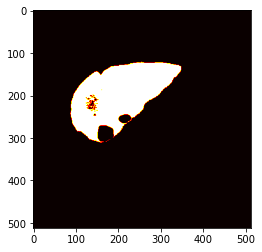

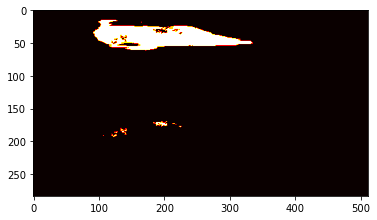

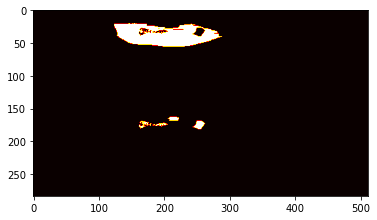

In [4]:
segmentation = dicom.dcmread(segmentation_path)

plt.imshow(segmentation.pixel_array[40, :, :], cmap='hot')
plt.show()

plt.imshow(segmentation.pixel_array[:, 200, :], cmap='hot')
plt.show()

plt.imshow(segmentation.pixel_array[:, :, 200], cmap='hot')
plt.show()

In [5]:
# Let's print the shape of the pixel_array
segmentation.pixel_array.shape

(284, 512, 512)

## Studying Header Information

Since we have two different sources of information- the CT scan and the segmentation (of the liver from the rest of the image), we need a way to match the respective frames in the DICOM data. In other words, we are looking for a way to check which segmentation corresponds to which slice in the data. Fortunately, when we load the data, we also get the DICOM headers which contain useful information.

Some useful headers include:
- 'Acquisition Number': This header indicates the acquisition order or number assigned to a particular frame or image in a series. It helps identify the sequence of acquisitions within a study or series.

- 'Slice Index': This header represents the position or index of a slice within a volume or series of images. It provides the slice number or index to help locate the position of a specific image within a 3D dataset.

- 'Per-frame Functional Groups Sequence' - 'Image Position Patient': This header provides the patient's position information for each frame or image. It specifies the 3D coordinates (X, Y, Z) in the patient coordinate system that define the position of the image in the physical space.

- 'Segment Identification Sequence' - 'Referenced Segment Number': In DICOM segmentation objects, multiple segments may be present, each representing a different region or structure of interest. The 'Referenced Segment Number' header specifies which segment a particular frame or image is associated with. It helps establish the correspondence between individual frames and the specific segment they represent.

In [22]:
data_seg = pd.DataFrame()
data_seg["ImagePositionPatient"]=patient_positions
data_seg["ReferencedSegmentNumber"]=ref_seg_nums 
data_seg["ReferencedSOPInstanceUID"]=ref_sop_InstanceUID

data_seg[data_seg.ReferencedSegmentNumber==2].head()

,ImagePositionPatient,ReferencedSegmentNumber,ReferencedSOPInstanceUID
71,"[-2.282000e+02, -1.863000e+02, -3.700000e+02]",2,1.3.6.1.4.1.14519.5.2.1.1706.8374.232612230945...
72,"[-2.282000e+02, -1.863000e+02, -3.675000e+02]",2,1.3.6.1.4.1.14519.5.2.1.1706.8374.426726062718...
73,"[-2.282000e+02, -1.863000e+02, -3.650000e+02]",2,1.3.6.1.4.1.14519.5.2.1.1706.8374.224321006968...
74,"[-2.282000e+02, -1.863000e+02, -3.625000e+02]",2,1.3.6.1.4.1.14519.5.2.1.1706.8374.201689324273...
75,"[-2.282000e+02, -1.863000e+02, -3.600000e+02]",2,1.3.6.1.4.1.14519.5.2.1.1706.8374.820782685913...


In [6]:
# Access the segmentation pixel array
segmentation_data = segmentation.pixel_array

# Access the SegmentSequence to retrieve information about each segment
segments = segmentation.SegmentSequence
segment_nums = []
segment_labels = []
patient_positions = []
dimension_index = []
ref_seg_nums = []
ref_sop_InstanceUID = []
for segment in segments:
    segment_number = segment.SegmentNumber
    segment_label = segment.SegmentLabel
    
    segment_nums.append(segment_number)
    segment_labels.append(segment_label)
    # Access more attributes as needed

# Access the PerFrameFunctionalGroupsSequence to retrieve information about each frame
frames = segmentation.PerFrameFunctionalGroupsSequence
for frame in frames:
    patient_pos = frame.PlanePositionSequence[0].ImagePositionPatient 
    patient_positions.append(patient_pos)
    dim_index = frame.FrameContentSequence[0].DimensionIndexValues 
    dimension_index.append(dim_index)
    ref_seg = frame.SegmentIdentificationSequence[0].ReferencedSegmentNumber 
    ref_seg_nums.append(ref_seg)
    sop_uid = frame.DerivationImageSequence[0].SourceImageSequence[0].ReferencedSOPInstanceUID
    ref_sop_InstanceUID.append(sop_uid)

We can add the information to a dataframe which makes it easy to visualize and compare.

# CT Scan Images

Here, I have created a function to parse header information and generate a dataframe for a folder of dicom images

In [134]:
def dicom2csv(extract = [],
              move_on = [(0x7FE0,0x0008), (0x7FE0,0x0009), (0x7FE0,0x0010)],
              folder_path = str(),
              csv_file_name = "metadata.csv",
              return_dataframe = False):
  
    '''
    Extract specific DICOM metadata from multiple DICOM files collected in a
    specified folder.
    ::Params
      - extract (list):
          The keywords of the DICOM attributes you want to extract.
      - move_on (list):
          The tags of the DICOM attributes you don't want to move on.
          By default,it contains a list of the tags of pixel data:
          [(0x7FE0,0x0008), (0x7FE0,0x0009), (0x7FE0,0x0010)]
          If you want to move on onto some attributes, it's recommended
          to append its unique tags in addition to pixel data tags.
      - folder_path (string):
          Path of the folder that contains the DICOM files.
      - csv_file_name (string):
          The name of the CSV file.
      - return_dataframe (bool):
          if True, returns a pandas dataframe of the extracted data for
          direct use.

    :: Returns
      - CSV file contains DICOM metadata specified the parameter extracted.
      - Pandas dataframe when return_dataframe is set to True.

    :: Example:
      dicom2csv(extract = ['StudyDate'],
                folder_path = 'content/dicomfolder',
                csv_file_name = "Study_Dates.csv",
                return_dataframe = True)
    '''
  
    # Initialize the meta dictionary that will have the specified attributes
    meta = {keyword:[] for keyword in extract}

    # List the files' names that we want to extract data from
    #dicom_files = glob.glob(folder_path+'/*.dcm')
    dicom_files = glob.glob(folder_path)

    # Iterate over each DICOM file in the folder and read it using dcmread()
    for file_path in dicom_files:
        # Read the DICOM file from the specified path
        dcm = dicom.dcmread(file_path)

        # Iterate over the DICOM attributes in the current DICOM file "dcm"
        for elem in dcm.iterall():
              # Ensure that the attribute is not a pixel data and it's one of the
              # required attributes
              if (elem.tag not in move_on) and (elem.keyword in extract):
                # Append the value of the current attribute
                meta[elem.keyword].append(elem.value)

    # Create a pandas dataframe for better use of the data
    df = pd.DataFrame(data=meta, columns = extract)

    # Create the CSV file with the specified name
    df.to_csv(csv_file_name, index=False)

    # Return the extracted dataframe for direct use
    if return_dataframe:
        return df

Similarly, we can create a DataFrame for the CT scan images as well

In [145]:
extract = ['SliceLocation', 'AcquisitionNumber', 'SeriesNumber', 'ImagePositionPatient', 'ImageType', 'InstanceNumber','SOPInstanceUID', 'PixelData']
df = dicom2csv(extract = extract[:-1],
               move_on = [],
               folder_path = img_folder_path,
               csv_file_name = 'data.csv', 
               return_dataframe = True)
df.head()

,SliceLocation,AcquisitionNumber,SeriesNumber,ImagePositionPatient,ImageType,InstanceNumber,SOPInstanceUID
0,-195.0,1,5,"[-228.199997, -186.300003, -195.000000]","[ORIGINAL, PRIMARY, AXIAL]",1,1.3.6.1.4.1.14519.5.2.1.1706.8374.131165155112...
1,-197.5,1,5,"[-228.199997, -186.300003, -197.500000]","[ORIGINAL, PRIMARY, AXIAL]",2,1.3.6.1.4.1.14519.5.2.1.1706.8374.934344731560...
2,-200.0,1,5,"[-228.199997, -186.300003, -200.000000]","[ORIGINAL, PRIMARY, AXIAL]",3,1.3.6.1.4.1.14519.5.2.1.1706.8374.353895568397...
3,-202.5,1,5,"[-228.199997, -186.300003, -202.500000]","[ORIGINAL, PRIMARY, AXIAL]",4,1.3.6.1.4.1.14519.5.2.1.1706.8374.745781556170...
4,-205.0,1,5,"[-228.199997, -186.300003, -205.000000]","[ORIGINAL, PRIMARY, AXIAL]",5,1.3.6.1.4.1.14519.5.2.1.1706.8374.277556011690...


## Useful Check: Single Acquistion 
Do the slices of CT image contain only a single acquisition? We can check this as follows

In [146]:
df.AcquisitionNumber.unique() # yes, all CT scan slices belong to a single acquisition

array([1], dtype=int64)

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SliceLocation         71 non-null     float64
 1   AcquisitionNumber     71 non-null     int64  
 2   SeriesNumber          71 non-null     int64  
 3   ImagePositionPatient  71 non-null     object 
 4   ImageType             71 non-null     object 
 5   InstanceNumber        71 non-null     int64  
 6   SOPInstanceUID        71 non-null     object 
dtypes: float64(1), int64(3), object(3)
memory usage: 4.0+ KB


In [148]:
data_seg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ImagePositionPatient      284 non-null    object
 1   ReferencedSegmentNumber   284 non-null    int64 
 2   ReferencedSOPInstanceUID  284 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.8+ KB


After analysing the data, I noticed that in these two DataFrames, the ImagePositionPatient columns can be used to match the indices and get a slice-to-slice correspondence between CT scans and segmentation slices. Similarly, the ReferencedSOPInstanceUID column in the segmentation header and the SOPInstanceUID in the header of CT scan slices can be used to match the indices. We match using the merge operation in pandas dataframe.

In [149]:
# Perform inner join on column
merged_df = pd.merge(df, data_seg, left_on='SOPInstanceUID', right_on='ReferencedSOPInstanceUID', how='inner')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 0 to 283
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SliceLocation             284 non-null    float64
 1   AcquisitionNumber         284 non-null    int64  
 2   SeriesNumber              284 non-null    int64  
 3   ImagePositionPatient_x    284 non-null    object 
 4   ImageType                 284 non-null    object 
 5   InstanceNumber            284 non-null    int64  
 6   SOPInstanceUID            284 non-null    object 
 7   ImagePositionPatient_y    284 non-null    object 
 8   ReferencedSegmentNumber   284 non-null    int64  
 9   ReferencedSOPInstanceUID  284 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 24.4+ KB


# Merged DataFrame
When we study this merged dataframe, the situation becomes clear. Each CT scan image has 4 corresponding slices in the segmentation image. They reference 1 segment each.

In [150]:
merged_df

,SliceLocation,AcquisitionNumber,SeriesNumber,ImagePositionPatient_x,ImageType,InstanceNumber,SOPInstanceUID,ImagePositionPatient_y,ReferencedSegmentNumber,ReferencedSOPInstanceUID
0,-195.0,1,5,"[-228.199997, -186.300003, -195.000000]","[ORIGINAL, PRIMARY, AXIAL]",1,1.3.6.1.4.1.14519.5.2.1.1706.8374.131165155112...,"[-2.282000e+02, -1.863000e+02, -1.950000e+02]",1,1.3.6.1.4.1.14519.5.2.1.1706.8374.131165155112...
1,-195.0,1,5,"[-228.199997, -186.300003, -195.000000]","[ORIGINAL, PRIMARY, AXIAL]",1,1.3.6.1.4.1.14519.5.2.1.1706.8374.131165155112...,"[-2.282000e+02, -1.863000e+02, -1.950000e+02]",2,1.3.6.1.4.1.14519.5.2.1.1706.8374.131165155112...
2,-195.0,1,5,"[-228.199997, -186.300003, -195.000000]","[ORIGINAL, PRIMARY, AXIAL]",1,1.3.6.1.4.1.14519.5.2.1.1706.8374.131165155112...,"[-2.282000e+02, -1.863000e+02, -1.950000e+02]",3,1.3.6.1.4.1.14519.5.2.1.1706.8374.131165155112...
3,-195.0,1,5,"[-228.199997, -186.300003, -195.000000]","[ORIGINAL, PRIMARY, AXIAL]",1,1.3.6.1.4.1.14519.5.2.1.1706.8374.131165155112...,"[-2.282000e+02, -1.863000e+02, -1.950000e+02]",4,1.3.6.1.4.1.14519.5.2.1.1706.8374.131165155112...
4,-197.5,1,5,"[-228.199997, -186.300003, -197.500000]","[ORIGINAL, PRIMARY, AXIAL]",2,1.3.6.1.4.1.14519.5.2.1.1706.8374.934344731560...,"[-2.282000e+02, -1.863000e+02, -1.975000e+02]",1,1.3.6.1.4.1.14519.5.2.1.1706.8374.934344731560...
...,...,...,...,...,...,...,...,...,...,...
279,-367.5,1,5,"[-228.199997, -186.300003, -367.500000]","[ORIGINAL, PRIMARY, AXIAL]",70,1.3.6.1.4.1.14519.5.2.1.1706.8374.426726062718...,"[-2.282000e+02, -1.863000e+02, -3.675000e+02]",4,1.3.6.1.4.1.14519.5.2.1.1706.8374.426726062718...
280,-370.0,1,5,"[-228.199997, -186.300003, -370.000000]","[ORIGINAL, PRIMARY, AXIAL]",71,1.3.6.1.4.1.14519.5.2.1.1706.8374.232612230945...,"[-2.282000e+02, -1.863000e+02, -3.700000e+02]",1,1.3.6.1.4.1.14519.5.2.1.1706.8374.232612230945...
281,-370.0,1,5,"[-228.199997, -186.300003, -370.000000]","[ORIGINAL, PRIMARY, AXIAL]",71,1.3.6.1.4.1.14519.5.2.1.1706.8374.232612230945...,"[-2.282000e+02, -1.863000e+02, -3.700000e+02]",2,1.3.6.1.4.1.14519.5.2.1.1706.8374.232612230945...
282,-370.0,1,5,"[-228.199997, -186.300003, -370.000000]","[ORIGINAL, PRIMARY, AXIAL]",71,1.3.6.1.4.1.14519.5.2.1.1706.8374.232612230945...,"[-2.282000e+02, -1.863000e+02, -3.700000e+02]",3,1.3.6.1.4.1.14519.5.2.1.1706.8374.232612230945...


We can see from the DataFrame above that the x, y coordinates are same. only last coordinate (which is actually the slice location) varies. Therefore, we can create a dict with pixel data of CT images and have slice location as the key.

In [151]:
pixel_data = {}
aquisition_num = [] # we need to ensure that slices of the CT image contain only a single acquisition.
paths = glob.glob(img_folder_path)
for path in paths:
    dataset = dicom.dcmread(path)
    aquisition_num.append(dataset.AcquisitionNumber)
    pixel_data[float(dataset.SliceLocation)] = dataset.pixel_array #Slice Location # Instance Number # Image Position (Patient)

In [123]:
# Let's sort according to the slice location
sorted_pixel_data = {key:pixel_data[key] for key in sorted(pixel_data.keys())}

Now, based on the sorted images and segmentations, we can access the frames easily as shown below

In [42]:
idx = 20
key = list(sorted_pixel_data.keys())[idx]
key

-320.0

In [18]:
# This is how we access patient data. See how slice location is the same
patient_positions[idx], patient_positions[idx+71], patient_positions[idx+2*71], patient_positions[idx+3*71]

([-2.282000e+02, -1.863000e+02, -3.200000e+02],
 [-2.282000e+02, -1.863000e+02, -3.200000e+02],
 [-2.282000e+02, -1.863000e+02, -3.200000e+02],
 [-2.282000e+02, -1.863000e+02, -3.200000e+02])

In [19]:
segment_labels # TODO: if Pedro replies about these, then use them in the plot as headings

['Liver', 'Mass', 'Portal vein', 'Abdominal aorta']

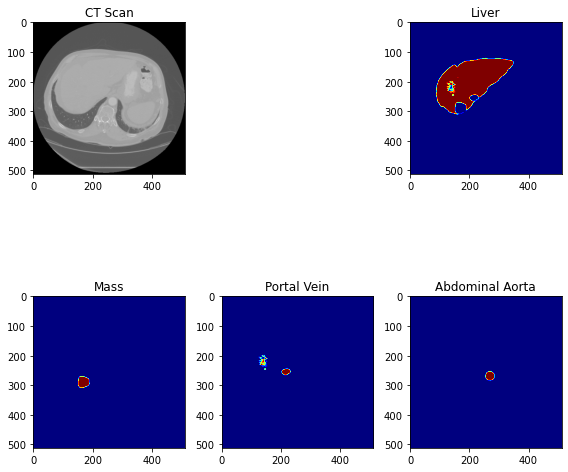

In [24]:
idx = 40
key = list(sorted_pixel_data.keys())[idx]
# Plot CT scan
plt.figure(figsize=(8, 8))
plt.subplot(2, 3, 1)
plt.imshow(sorted_pixel_data[key], cmap='gray', vmax = np.max(sorted_pixel_data[key]), vmin=np.min(sorted_pixel_data[key])) 
plt.title('CT Scan')

# Plot segmentation mask
plt.subplot(2, 3, 3)
plt.imshow(segmentation.pixel_array[idx,:,:], cmap='jet')
plt.title('Liver')
#plt.title(segment_labels[0])

# Plot segmentation mask
plt.subplot(2, 3, 4)
plt.imshow(segmentation.pixel_array[1*71 + idx,:,:], cmap='jet')
plt.title('Mass')

# Plot segmentation mask
plt.subplot(2, 3, 5)
plt.imshow(segmentation.pixel_array[2*71 + idx,:,:], cmap='jet')
plt.title('Portal Vein')

# Plot segmentation mask
plt.subplot(2, 3, 6)
plt.imshow(segmentation.pixel_array[3*71 + idx,:,:], cmap='jet')
plt.title('Abdominal Aorta')

# Show the plot
plt.tight_layout()
plt.show()

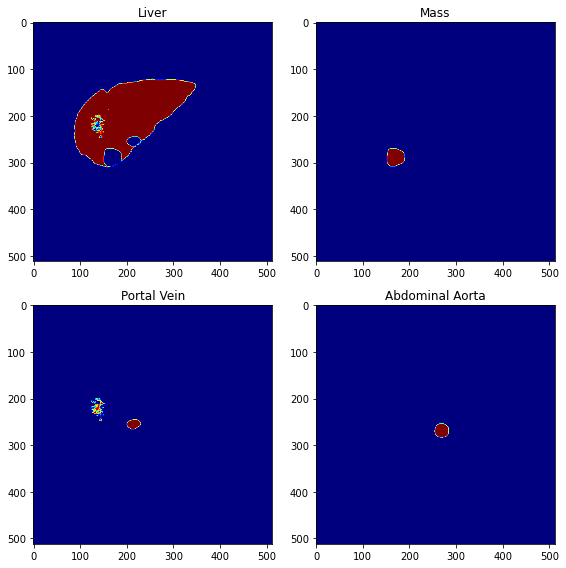

In [26]:
idx = 40
key = list(sorted_pixel_data.keys())[idx]
plt.figure(figsize=(8, 8))
# Plot segmentation mask
plt.subplot(2, 2, 1)
plt.imshow(segmentation.pixel_array[idx,:,:], cmap='jet')
plt.title('Liver')
#plt.title(segment_labels[0])

# Plot segmentation mask
plt.subplot(2, 2, 2)
plt.imshow(segmentation.pixel_array[1*71 + idx,:,:], cmap='jet')
plt.title('Mass')

# Plot segmentation mask
plt.subplot(2, 2, 3)
plt.imshow(segmentation.pixel_array[2*71 + idx,:,:], cmap='jet')
plt.title('Portal Vein')

# Plot segmentation mask
plt.subplot(2, 2, 4)
plt.imshow(segmentation.pixel_array[3*71 + idx,:,:], cmap='jet')
plt.title('Abdominal Aorta')

# Show the plot
plt.tight_layout()
plt.show()

## Alpha Fusion
Alpha fusion, also known as alpha blending or alpha compositing, is a technique used in medical imaging to combine multiple images or datasets into a single composite image. It is a form of image fusion that allows for the simultaneous visualization and integration of information from different imaging modalities or image sources.

In alpha fusion, each pixel of the composite image is calculated by blending the pixel values from the input images using a weighting factor called alpha (α). The alpha value determines the contribution or opacity of each input image to the final composite image. The blending process is often performed using a linear combination of the pixel values weighted by their respective alpha values.

The alpha value typically ranges between 0 and 1, where 0 indicates complete transparency (the pixel is not visible in the composite image) and 1 indicates complete opacity (the pixel is fully visible in the composite image). Intermediate alpha values allow for partial visibility and smooth transitions between the input images

In [162]:
def apply_cmap(img, cmap_name, normalize=True) -> np.ndarray:
    """ Apply a colormap to a 2D image. """
    if normalize:
        img = (img - np.min(img))/np.ptp(img)
    cmap_function = matplotlib.cm.get_cmap(cmap_name)
    return cmap_function(img)


def visualize_alpha_fusion(image: np.ndarray, mask: np.ndarray, alpha, visualize = True):
    """ Visualize both image and mask in the same plot. """
    # threshold image
    img = image.copy()
    img[img < 200] = 200
    img[img > 1500] = 1500
    img_cmapped = apply_cmap(img, cmap_name='bone')    # Why 'bone'?
    mask_bone_cmapped = apply_cmap(mask, cmap_name='prism')     # Why 'prism'?
    mask_bone_cmapped = mask_bone_cmapped * mask[..., np.newaxis].astype('bool')
    img_new = img_cmapped * (1-alpha) + mask_bone_cmapped * alpha
    if visualize:
        plt.figure(figsize=(15, 8))
        plt.subplot(1, 3, 1)
        plt.imshow(img_cmapped)
        plt.title('CT Scan')

        # Plot segmentation mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask_bone_cmapped)
        plt.title('Segmentation')

        plt.subplot(1, 3, 3)
        plt.imshow(img_cmapped * (1-alpha) + mask_bone_cmapped * alpha, aspect=1)
        plt.title(f'Segmentation with alpha {alpha}')
        #plt.colorbar()
        plt.show()
    else:
        return img_new

In [163]:
# Trick to merge all 4 segmentation regions into 1
all_regions = segmentation.pixel_array[idx,:,:]*0.2+ segmentation.pixel_array[idx+71,:,:]*0.4+segmentation.pixel_array[idx+2*71,:,:]*0.6+ segmentation.pixel_array[idx+3*71,:,:]*0.9

In [164]:
np.unique(segmentation.pixel_array[idx+71,:,:])

array([0, 1], dtype=uint8)

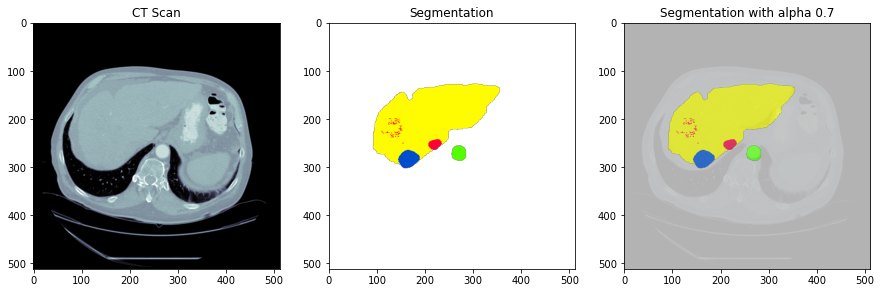

In [165]:
idx = 41
key = list(sorted_pixel_data.keys())[idx]
visualize_alpha_fusion(sorted_pixel_data[key], all_regions, 0.7)

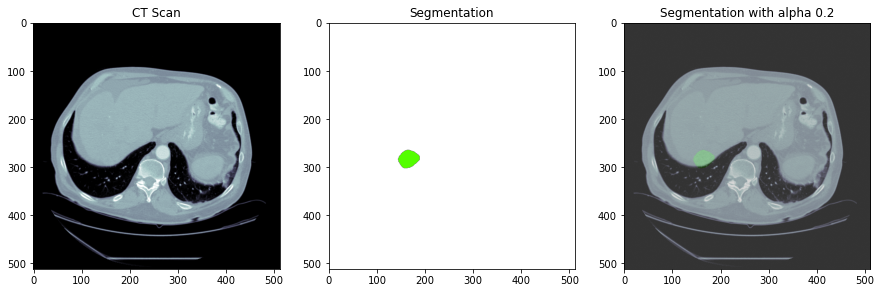

In [166]:
idx = 44
key = list(sorted_pixel_data.keys())[idx]
visualize_alpha_fusion(sorted_pixel_data[key], segmentation.pixel_array[idx+71,:,:], 0.2)

Now lets do this combination of segments and arrangement of all CT scan slices into two arrays which we would use for alpha fusion and combination

In [124]:
block_ct = np.array([i for i in sorted_pixel_data.values()]) # 71*512*512
block_seg1 = np.array([segmentation.pixel_array[idx,:,:] for idx in range(block_ct.shape[0])])
block_seg2 = np.array([segmentation.pixel_array[idx+71,:,:] for idx in range(block_ct.shape[0])])
block_seg3 = np.array([segmentation.pixel_array[idx+71*2,:,:] for idx in range(block_ct.shape[0])])
block_seg4 = np.array([segmentation.pixel_array[idx+71*3,:,:] for idx in range(block_ct.shape[0])])
block_seg = block_seg1*0.2 + block_seg2*0.4 + block_seg3*0.7 + block_seg4*0.9
assert block_ct.shape == block_seg.shape

# Animation
Here, we are rotating on an axis parallel to the axial axix, creating a maximal intensity projection and making an animation

In [ ]:
img_dcm = block_ct
def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)
def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the sagittal orientation. """
    return np.max(img_dcm, axis=2)

# Got this info from the header: Slice Thickness and Pixel Spacing
pixel_len_mm = [2.5, 0.859375, 0.859375]
# Create projections varying the angle of rotation
#   Configure visualization colormap
img_min = np.amin(img_dcm)
img_max = np.amax(img_dcm)
cm = matplotlib.cm.get_cmap('bone')
fig, ax = plt.subplots()
#   Configure directory to save results
#os.makedirs('./', exist_ok=True)
#   Create projections
n = 36
projections = []
for idx, alpha in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    rotated_img = rotate_on_axial_plane(img_dcm, alpha)
    projection = MIP_sagittal_plane(rotated_img)
    plt.imshow(projection, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])
    plt.savefig(f'./Projection_{idx}.png')      # Save animation
    projections.append(projection)  # Save for later animation
# Save and visualize animation
animation_data = [
    [plt.imshow(img, animated=True, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])]
    for img in projections
]
anim = animation.ArtistAnimation(fig, animation_data,
                          interval=250, blit=True)
anim.save('./Animation1.gif')  # Save animation
plt.show()                              # Show animation


# Final Product
Put it all together now

MovieWriter ffmpeg unavailable; using Pillow instead.


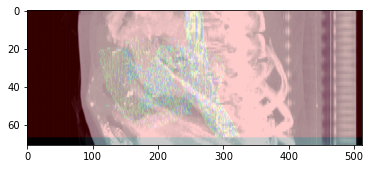

In [168]:
alpha = 0.2
fig, ax = plt.subplots()

#   Create projections
n = 36
projections = []
for idx, rot in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    # first, rotate the CT image block
    rotated_img = rotate_on_axial_plane(img_dcm, rot)
    # then, rotate the segmentation block
    rotated_seg = rotate_on_axial_plane(block_seg, rot)
    
    projection_img = MIP_sagittal_plane(rotated_img)
    projection_seg = MIP_sagittal_plane(rotated_seg)
    
    projection = visualize_alpha_fusion(projection_img, projection_seg, alpha, visualize = False)
    plt.imshow(projection) #, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])
    plt.savefig(f'./Projection_{idx}.png')      # Save animation
    projections.append(projection)  # Save for later animation
# Save and visualize animation
animation_data = [
    [plt.imshow(img, animated=True, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])]
    for img in projections
]
anim = animation.ArtistAnimation(fig, animation_data,
                          interval=250, blit=True)
anim.save('./Animation_all.gif')  # Save animation
plt.show()   # Show animation


MovieWriter ffmpeg unavailable; using Pillow instead.


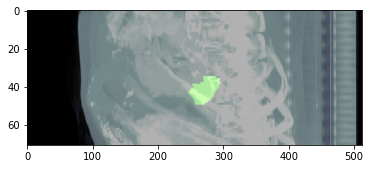

In [129]:
alpha = 0.3
fig, ax = plt.subplots()

#   Create projections
n = 36
projections = []
for idx, rot in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    # first, rotate the CT image block
    rotated_img = rotate_on_axial_plane(img_dcm, rot)
    # then, rotate the segmentation block
    rotated_seg = rotate_on_axial_plane(block_seg2, rot)
    
    projection_img = MIP_sagittal_plane(rotated_img)
    projection_seg = MIP_sagittal_plane(rotated_seg)
    
    projection = visualize_alpha_fusion(projection_img, projection_seg, alpha, visualize = False)
    plt.imshow(projection) #, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])
    plt.savefig(f'./Projection_{idx}.png')      # Save animation
    projections.append(projection)  # Save for later animation
# Save and visualize animation
animation_data = [
    [plt.imshow(img, animated=True, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])]
    for img in projections
]
anim = animation.ArtistAnimation(fig, animation_data,
                          interval=250, blit=True)
anim.save('./Animation_mass.gif')  # Save animation
plt.show()   # Show animation
